rappel information SAM `Predictor.forward` sur multimask_output :
>  multimask_output (bool): If true, the model will return three masks.
For ambiguous input prompts (such as a single click), this will often
produce better masks than a single prediction. If only a single
mask is needed, the model's predicted quality score can be used
to select the best mask. For non-ambiguous prompts, such as multiple
input prompts, multimask_output=False can give better results.

In [1]:
import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence

from src.commons.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample, resize
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import IMG_SIZE
from src.data.process import generate_grid_prompt
from src.commons.utils import create_sample_grid_with_prompt, get_mask_with_prompt, fig2arr

In [2]:
from src.commons.utils_io import load_sam
from src.models.commons.bisam import BiSam2, SamModeInference
from src.models.commons.model import BiSam

from src.commons.utils import batch_to_list

In [3]:
def show_prompts_on_mask(mask: torch.Tensor, batch, batch_idx: int):
    if mask.shape[-1] != IMG_SIZE[0]:
        mask = resize(mask, IMG_SIZE)
    coord_points = batch["point_coords"][batch_idx]
    mask_pt = get_mask_with_prompt(binarize_mask(mask[batch_idx], th=0) , coord_points)
    show_img(mask_pt)

In [4]:
from src.data.loader import BiTemporalDataset
from src.data.process import DefaultTransform
from omegaconf import OmegaConf

params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape":3,
    "loc": "center",
    "batch_size": 2,
}
ds = BiTemporalDataset(
            name="levir-cd",
            dtype="test",
            transform=DefaultTransform(),
            params=OmegaConf.create(params),
        )

In [5]:
dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
        )

In [48]:
batch = next(iter(dloader))

/home/MDizier/data/dl/levir-cd/test/label/test_1.png
/home/MDizier/data/dl/levir-cd/test/label/test_2.png


In [48]:
bisam2 = load_sam(
    model_type="vit_b", model_cls=BiSam2, version= "dev2", device="cpu"
)

2024-07-19 17:35:01,002 - INFO ::  build vit_b BiSam2


In [59]:
bisam = load_sam(
    model_type="vit_b", model_cls=BiSam, version= "dev", device="cpu"
)

2024-07-19 17:41:10,544 - INFO ::  build vit_b BiSam


In [15]:
out = bisam2(batch, multimask_output=True)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


### multioutput == True

In [42]:
preds = (out["masks"] > 0.).squeeze(2)

In [43]:
preds.shape

torch.Size([2, 1, 256, 256])

In [19]:
idx_max = torch.argmax(out["iou_predictions"], dim=2)
expanded_indices = idx_max.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 1, 256, 256)
# Use gather to select elements along dim 2
selected_elements = torch.gather(preds, 2, expanded_indices).squeeze(2)

In [70]:
selected_elements.shape

torch.Size([2, 256, 256])

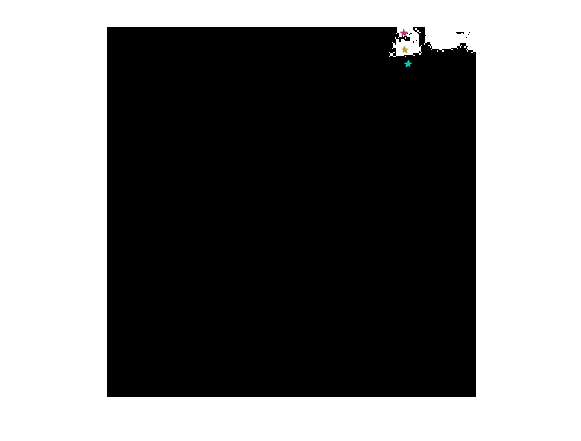

In [69]:
show_prompts_on_mask(selected_elements.squeeze(1), batch, 0)

In [22]:
selected_elements.shape

torch.Size([2, 1, 256, 256])

### multioutput == False

In [61]:
out = bisam2(batch, multimask_output=False)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


In [62]:
out["masks"].shape

torch.Size([2, 1, 1, 256, 256])

In [63]:
preds = bisam2.upscale_masks(out["masks"], (1024, 1024))

In [64]:
preds.shape

torch.Size([2, 1, 1, 1024, 1024])

In [65]:
preds = (preds > 0.).squeeze(1)
preds.shape

torch.Size([2, 1024, 1024])

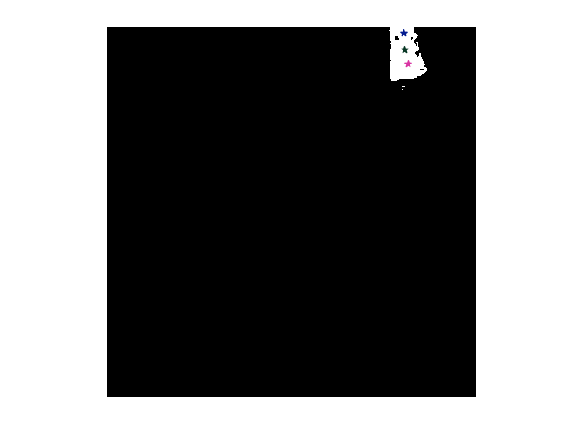

In [71]:
show_prompts_on_mask(preds, batch, 0)

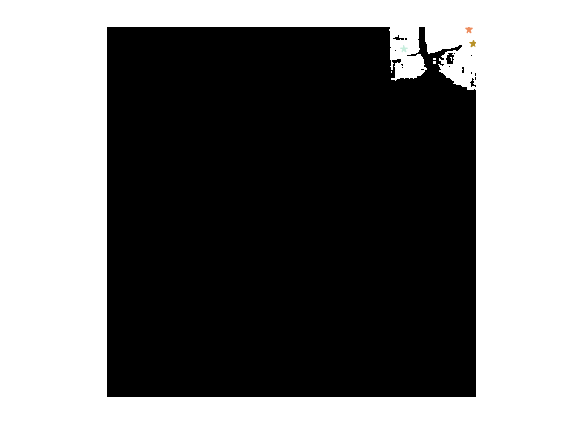

In [33]:
idx = 0
mask = preds[idx]
coord_points = batch["point_coords"][idx]
mask_pt = get_mask_with_prompt(mask, coord_points)
show_img(mask_pt)

On prédit un seul masque dans les deux cas car tous les pormpts sont associés à un meme objet !

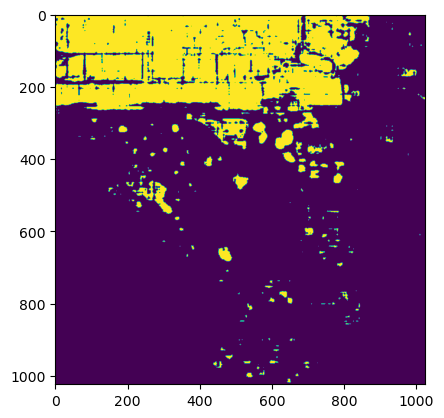

In [14]:
plt.imshow(to_numpy(preds[1], transpose=False))

In [13]:
preds[0].shape

torch.Size([1024, 1024])

In [4]:
from src.models.segment_anything import sam_model_registry_ori, SamPredictor
from src.commons.constants import SAM_MODEL_SMALL_PATH

idx= 0
img_path = f"/home/MDizier/data/dl/levir-cd/test/B/test_{idx+1}.png"

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

device = "cpu"
model_type = "vit_b"

sam = sam_model_registry_ori[model_type](checkpoint=SAM_MODEL_SMALL_PATH)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)


2024-07-19 17:20:49,911 - INFO ::  build SAM


In [73]:
batch["point_coords"][idx].shape

torch.Size([3, 2])

In [74]:
point_coords = batch["point_coords"][idx]
# remove padding points
point_coords = point_coords[torch.sum(point_coords, dim=1) > 0]
# remove padding points
point_labels = batch["point_labels"][idx]
point_labels = point_labels[:point_coords.shape[0]]  

input_point = to_numpy(point_coords, transpose=False)
input_label = to_numpy(point_labels, transpose=False)

In [75]:
input_label.shape, input_point.shape

((3,), (3, 2))

In [76]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

sparse emb : torch.Size([1, 4, 256])
dense emb : torch.Size([1, 256, 64, 64])
low mask  predict torch : torch.Size([1, 1, 256, 256])
low mask  predict torch : torch.Size([1, 1, 1024, 1024])


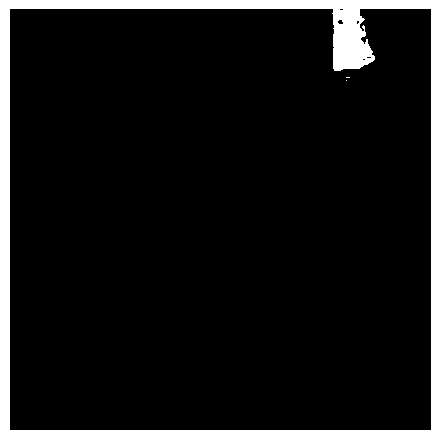

In [77]:
show_img(masks.squeeze())

### batch prompt
* un prompt == un objet

In [78]:
point_coords = batch["point_coords"][idx]
# remove padding points
point_coords = point_coords[torch.sum(point_coords, dim=1) > 0]
# remove padding points
point_labels = batch["point_labels"][idx]
point_labels = point_labels[:point_coords.shape[0]]  
input_point = point_coords.clone().to(device)
input_label = point_labels.clone().to(device)
input_point.shape, input_label.shape

(torch.Size([3, 2]), torch.Size([3]))

In [79]:
masks, ious, _ = predictor.predict_torch(
    point_coords=input_point[:,None ,:],
    point_labels=input_label[:, None],
    boxes=None,
    multimask_output=False,
)

sparse emb : torch.Size([3, 2, 256])
dense emb : torch.Size([3, 256, 64, 64])
low mask  predict torch : torch.Size([3, 1, 256, 256])
low mask  predict torch : torch.Size([3, 1, 1024, 1024])


In [80]:
masks.shape

torch.Size([3, 1, 1024, 1024])

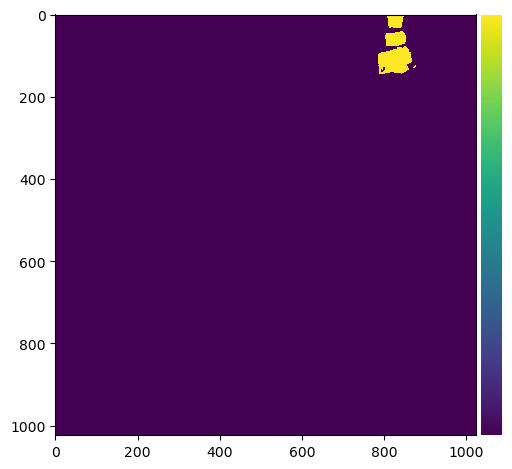

In [81]:
show_img(to_numpy(torch.sum(masks.squeeze(), dim=0), transpose=False))

Ok ! La onna chaque prompt pour un objet different!

In [85]:
batch["point_coords"].shape, input_point.shape

(torch.Size([2, 3, 2]), torch.Size([3, 2]))

In [87]:
idx = 0
masks, ious, _ = predictor.predict_torch(
    point_coords=batch["point_coords"][idx][None, : ,:].to(device),
    point_labels=batch["point_labels"][idx][None, :].to(device),
    boxes=None,
    multimask_output=False,
)

sparse emb : torch.Size([1, 4, 256])
dense emb : torch.Size([1, 256, 64, 64])
low mask  predict torch : torch.Size([1, 1, 256, 256])
low mask  predict torch : torch.Size([1, 1, 1024, 1024])


In [90]:
masks.shape

torch.Size([1, 1, 1024, 1024])

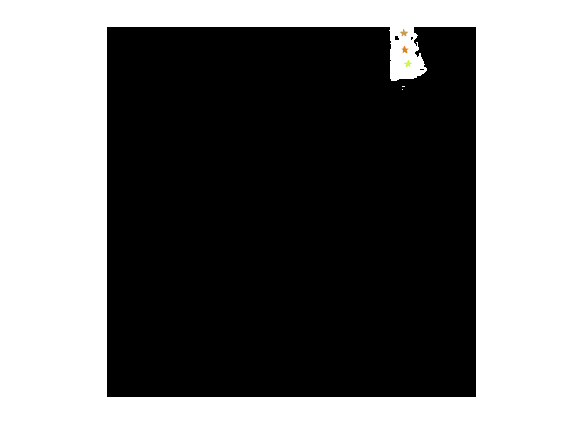

In [93]:
show_prompts_on_mask(masks.squeeze(0), batch, 0)

### change model : many prompt to one mask :

In [4]:
from src.commons.utils_io import load_config
import hydra
from hydra.core.global_hydra import GlobalHydra

In [12]:
GlobalHydra.instance().clear()
list_args=["experiment=mp_naive", "sam_type=small", "data=levir-cd", "data.params.n_shape=3", "data.params.num_worker=0"]
cfg = load_config(list_args)

In [13]:
module = hydra.utils.instantiate(cfg.model.instance)

In [15]:
data_module = hydra.utils.instantiate(cfg.data)

In [16]:
data_module.params

{'prompt_type': 'sample', 'n_prompt': 1, 'loc': 'center', 'batch_size': 2, 'n_shape': 3, 'num_worker': 0, 'pin_memory': False}

In [17]:
data_module.setup("fit")
train_dloader = data_module.train_dataloader()

In [18]:
batch = next(iter(train_dloader))

/home/MDizier/data/dl/levir-cd/train/label/train_1.png
/home/MDizier/data/dl/levir-cd/train/label/train_2.png


### Modif mask decoder

In [196]:
out = bisam2(batch, multimask_output=False)
preds2 = out["masks"] > 0
print(preds2.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([2, 1, 1, 256, 256])


In [93]:
out = bisam(batch, multimask_output=False, mode=SamModeInference.INTERACTIVE)
preds = out["masks"] > 0
print(preds.shape)

sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
torch.Size([2, 3, 1, 256, 256])


In [19]:
# bisam diff modified => 1 mask for all prompt
preds_diff2, ious = module.model(batch, multimask_output=False)
preds_diff2 = preds_diff2 > 0
print(preds_diff2.shape)

torch.Size([2, 1, 1, 256, 256])


In [197]:
point_coords = (
    batch["point_coords"].clone()
)
point_labels = (
    batch["point_labels"].clone()
)

In [198]:
batch["point_coords"]

tensor([[[623., 894.],
         [363., 958.],
         [310., 972.]],

        [[549., 711.],
         [951., 438.],
         [389., 822.]]])

In [200]:
point_coords.shape, point_labels.shape

(torch.Size([2, 3, 2]), torch.Size([2, 3]))

In [214]:
# batch prompt encoding
sparse_embeddings, dense_embeddings = bisam.prompt_encoder(
    points=(
        point_coords[:,:,None ,:],#[0][None, :, :],
        point_labels[..., None] #[0][None, :],
    ),
    boxes=None,
    masks=None,
)

In [213]:
sparse_embeddings, dense_embeddings = bisam2.prompt_encoder(
    points=(
        point_coords[:,None ,:],#[0][None, :, :],
        point_labels[:, None] #[0][None, :],
    ),
    boxes=None,
    masks=None,
)

RuntimeError: Tensors must have same number of dimensions: got 4 and 3

In [203]:
print(f"sparse_embeddings: {sparse_embeddings.shape}")
print(f"dense_embeddings: {dense_embeddings.shape}")

sparse_embeddings: torch.Size([2, 4, 256])
dense_embeddings: torch.Size([2, 256, 64, 64])


On veut sparse : 2, 4, 256

In [204]:
image_embeddings = bisam2.image_embeddings

In [205]:
image_embeddings.shape

torch.Size([2, 256, 64, 64])

In [206]:
low_res_masks, iou_predictions =  bisam2.mask_decoder(
    image_embeddings=image_embeddings,  # (B, 256, 64, 64)
    image_pe=bisam2.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
    sparse_prompt_embeddings=sparse_embeddings,  # (B, N, 2, 256)
    dense_prompt_embeddings=dense_embeddings,  # (B, N, 256, 64, 64)
    multimask_output=False,
)

In [215]:
low_res_masks, iou_predictions =  bisam2.mask_decoder(
    image_embeddings=image_embeddings[0].unsqueeze(0),  # (B, 256, 64, 64)
    image_pe=bisam2.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
    sparse_prompt_embeddings=sparse_embeddings[0],  # (B, N, 2, 256)
    dense_prompt_embeddings=dense_embeddings[0],  # (B, N, 256, 64, 64)
    multimask_output=False,
)

In [216]:
low_res_masks.shape

torch.Size([3, 1, 256, 256])

In [168]:
# masks =  module.model.upscale_masks(low_res_masks.unsqueeze(0), IMG_SIZE)
# # masks, iou_predictions =  module.model.select_masks(
# #     masks, iou_predictions, multimask_output=False
# # )

In [207]:
masks = masks > 0

In [174]:
masks.shape

torch.Size([1, 2, 1, 1024, 1024])

In [223]:
preds2.shape

torch.Size([2, 1, 1, 256, 256])

In [27]:
batch["label_path"]

['/home/MDizier/data/dl/levir-cd/train/label/train_1.png',
 '/home/MDizier/data/dl/levir-cd/train/label/train_2.png']

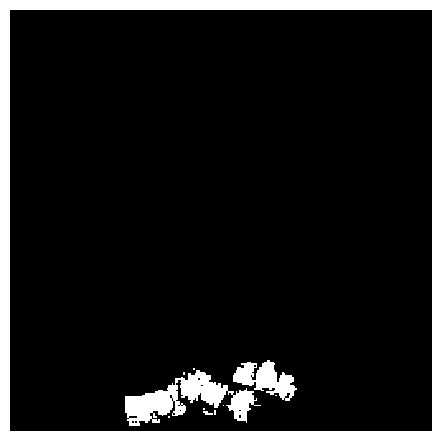

In [224]:
show_img(to_numpy(preds2[0].squeeze(), transpose=False))

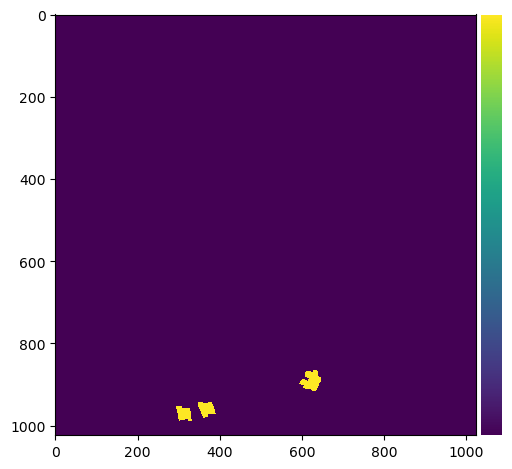

In [208]:
show_img(to_numpy(batch["label"][0], transpose=False))

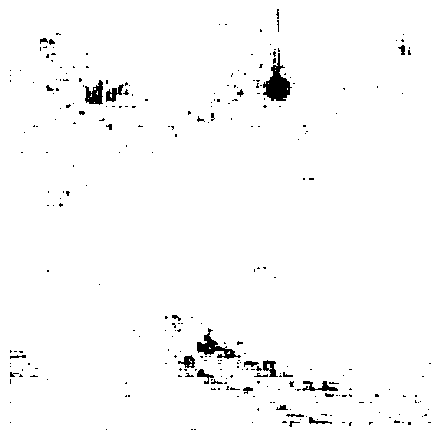

In [218]:
show_img(to_numpy(masks.squeeze()[0], transpose=False))

In [20]:
print(preds_diff2.shape)

torch.Size([2, 1, 1, 256, 256])


In [25]:
preds_diff2.dtype

torch.bool

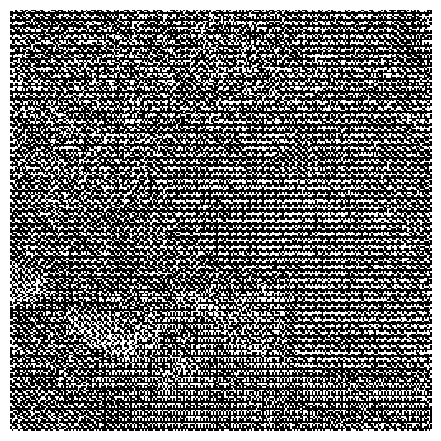

In [24]:
show_img(to_numpy(preds_diff2.squeeze()[0], transpose=False))

In [42]:
print(batch["label_path"])

['/home/MDizier/data/dl/levir-cd/train/label/train_1.png', '/home/MDizier/data/dl/levir-cd/train/label/train_2.png']


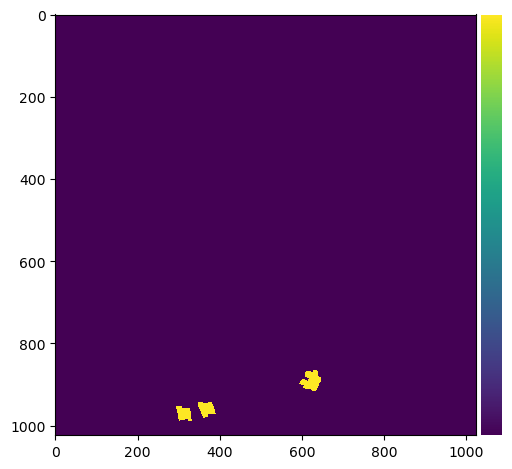

In [43]:
show_img(to_numpy(batch["label"][0], transpose=False))

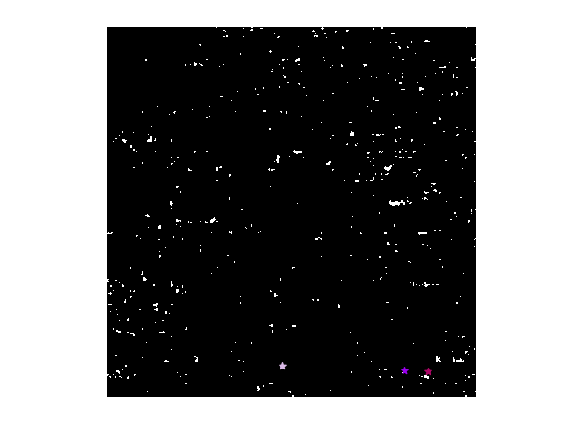

In [28]:
show_prompts_on_mask(masks[1].squeeze(0), batch, 0)

In [67]:
out = bisam2(batch, multimask_output=False)
preds2 = out["masks"] > 0
print(preds2.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([2, 1, 1, 256, 256])


In [93]:
out = bisam(batch, multimask_output=False, mode=SamModeInference.INTERACTIVE)
preds = out["masks"] > 0
print(preds.shape)

sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
torch.Size([2, 3, 1, 256, 256])


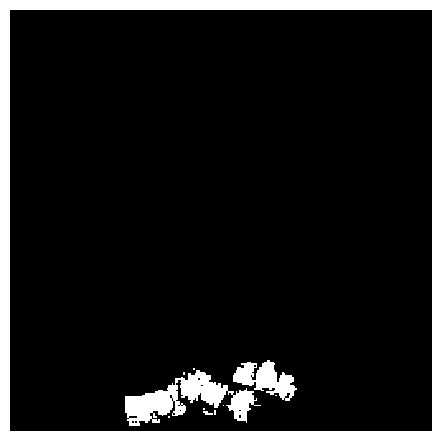

In [73]:
show_img(to_numpy(torch.sum(preds2.squeeze(2), dim=1)[0], transpose=False))

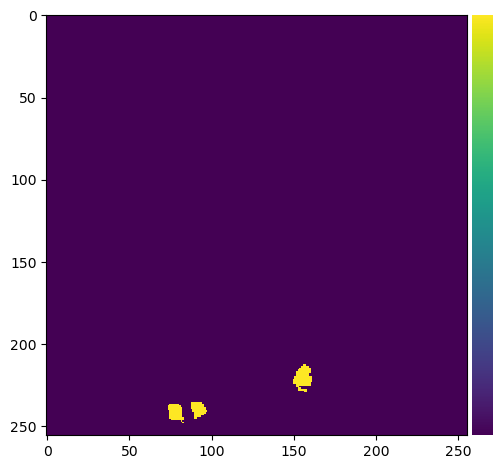

In [94]:
show_img(to_numpy(torch.sum(preds.squeeze(), dim=1)[0], transpose=False))

On a bine deux inférence différentes : 
* la premiere considère les points et extraits un seul mask.
* la deuxieme considère un mask par point

### Check predictor : ok

In [86]:
image = to_numpy(batch["img_B"][0]).astype(np.uint8)

In [87]:
image.dtype

dtype('uint8')

In [88]:
predictor = SamPredictor(sam)
predictor.set_image(image)

In [73]:
batch["point_coords"][idx].shape

torch.Size([3, 2])

In [89]:
idx=0
point_coords = batch["point_coords"][idx]
# remove padding points
point_coords = point_coords[torch.sum(point_coords, dim=1) > 0]
# remove padding points
point_labels = batch["point_labels"][idx]
point_labels = point_labels[:point_coords.shape[0]]  

input_point = to_numpy(point_coords, transpose=False)
input_label = to_numpy(point_labels, transpose=False)

In [90]:
input_label.shape, input_point.shape

((3,), (3, 2))

In [91]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

sparse emb : torch.Size([1, 4, 256])
dense emb : torch.Size([1, 256, 64, 64])
low mask  predict torch : torch.Size([1, 1, 256, 256])
low mask  predict torch : torch.Size([1, 1, 1024, 1024])


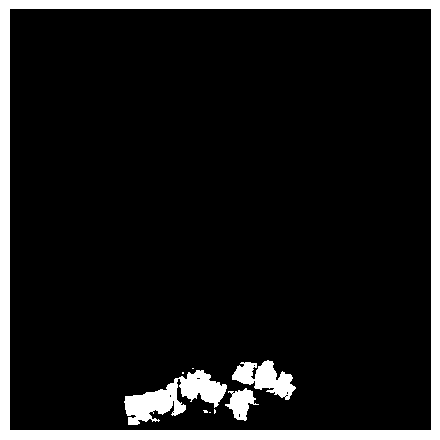

In [92]:
show_img(masks.squeeze())

TypeError: Invalid shape (3, 1024, 1024) for image data

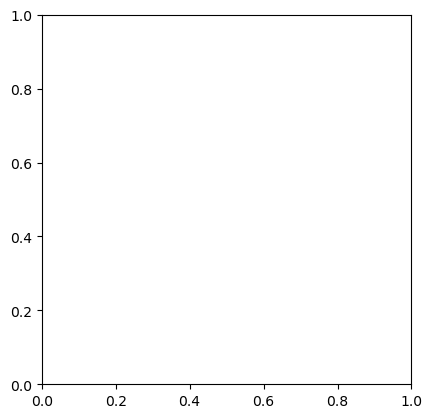

In [55]:
show_prompts_on_mask(preds.squeeze(), batch, 0)

In [28]:
module.model.prompt_encoder.get_dense_pe().shape

torch.Size([1, 256, 64, 64])